# FastText Experimenty

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '../Data/wiki-news-300d-1M.vec.zip'

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow import string as tf_string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import LSTM, GRU, Bidirectional

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from keras.layers import Embedding, Dropout, Dense, LSTM, GRU


In [ ]:
dataset = pd.read_csv('../DP/Data/final_dataset_3.csv')

## Split datasetu

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset['processed_text'], dataset['author_id'], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## One-hot encoder

In [ ]:
one_hot_encoder = OneHotEncoder()

y_train = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)).toarray()
y_valid = one_hot_encoder.transform(y_valid.to_numpy().reshape(-1, 1)).toarray()
y_test = one_hot_encoder.transform(y_test.to_numpy().reshape(-1, 1)).toarray()

In [ ]:
y_test.shape

(240, 20)

## Embdding matica

In [ ]:
embeddings_index = {}
with open('wiki-news-300d-1M.vec') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 999995 word vectors.


In [ ]:
embedding_dim = 300
vocab_size = 40000
sequence_length = 6000

vect_layer = TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vect_layer.adapt(X_train.values)

In [ ]:
voc = vect_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
num_tokens = len(voc) + 2
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 33168 words (6832 misses)


# Modely

## DNN model

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.GlobalAveragePooling1D()(emb)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation='relu')(x)
output_layer =  keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()

model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 6000, 300)         12000600  
                                                                 
 global_average_pooling1d (  (None, 300)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 1024)              308224

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='ft_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
batch_size = 32
epochs = 10

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/10
27/27 [==============================] - 83s 3s/step - loss: 2.9602 - accuracy: 0.0476 - val_loss: 2.9264 - val_accuracy: 0.1354
Epoch 2/10
27/27 [==============================] - 77s 3s/step - loss: 2.7866 - accuracy: 0.1775 - val_loss: 2.6990 - val_accuracy: 0.2500
Epoch 3/10
27/27 [==============================] - 82s 3s/step - loss: 2.3964 - accuracy: 0.2691 - val_loss: 2.2484 - val_accuracy: 0.3333
Epoch 4/10
27/27 [==============================] - 88s 3s/step - loss: 1.9693 - accuracy: 0.3886 - val_loss: 1.9085 - val_accuracy: 0.4167
Epoch 5/10
27/27 [==============================] - 87s 3s/step - loss: 1.6615 - accuracy: 0.4849 - val_loss: 1.7272 - val_accuracy: 0.4688
Epoch 6/10
27/27 [==============================] - 88s 3s/step - loss: 1.4462 - accuracy: 0.5777 - val_loss: 1.6043 - val_accuracy: 0.5000
Epoch 7/10
27/27 [==============================] - 81s 3s/step - loss: 1.3406 - accuracy: 0.5684 - val_loss: 1.5111 - val_accuracy: 0.5208
Epoch 8/10
27/27 [==

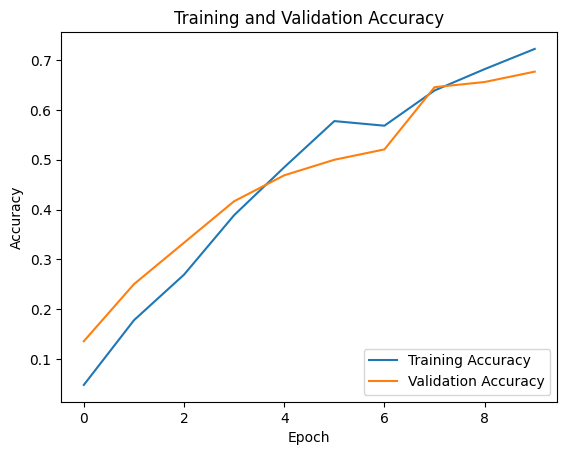

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 0s 30ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.6708333333333333
F1 Score: 0.6548130437600291
Precision: 0.702285200179937
Recall: 0.6708333333333333


## CNN Model

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf.string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = tf.keras.layers.Conv1D(512, kernel_size=4, padding="valid", activation="relu")(emb)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding_4 (Embedding)     (None, 6000, 300)         12000600  
                                                                 
 conv1d_2 (Conv1D)           (None, 5997, 512)         614912    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 2998, 512)         0         
 g1D)                                                            
                                                                 
 global_average_pooling1d_4  (None, 512)               0   

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='ft_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/15
27/27 [==============================] - 96s 4s/step - loss: 2.9489 - accuracy: 0.0615 - val_loss: 2.9075 - val_accuracy: 0.1042
Epoch 2/15
27/27 [==============================] - 90s 3s/step - loss: 2.7769 - accuracy: 0.1729 - val_loss: 2.6985 - val_accuracy: 0.1667
Epoch 3/15
27/27 [==============================] - 83s 3s/step - loss: 2.4961 - accuracy: 0.2471 - val_loss: 2.4401 - val_accuracy: 0.3750
Epoch 4/15
27/27 [==============================] - 82s 3s/step - loss: 2.1202 - accuracy: 0.4200 - val_loss: 2.0644 - val_accuracy: 0.4688
Epoch 5/15
27/27 [==============================] - 83s 3s/step - loss: 1.8358 - accuracy: 0.4617 - val_loss: 1.8194 - val_accuracy: 0.5521
Epoch 6/15
27/27 [==============================] - 91s 3s/step - loss: 1.6322 - accuracy: 0.5186 - val_loss: 1.5406 - val_accuracy: 0.6979
Epoch 7/15
27/27 [==============================] - 6s 204ms/step - loss: 1.3590 - accuracy: 0.6195 - val_loss: 1.5785 - val_accuracy: 0.5729
Epoch 8/15
27/27 [

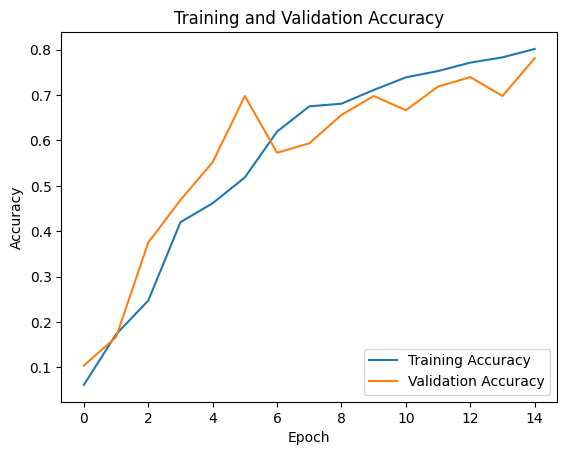

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 1s 93ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.8041666666666667
F1 Score: 0.8042504377712508
Precision: 0.8207714541721894
Recall: 0.8041666666666667


## Biderectional LSTMU

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(emb)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(256, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)

model = keras.Model(input_layer, output_layer)
model.summary()


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding_6 (Embedding)     (None, 6000, 300)         12000600  
                                                                 
 bidirectional_2 (Bidirecti  (None, 6000, 256)         439296    
 onal)                                                           
                                                                 
 global_average_pooling1d_6  (None, 256)               0         
  (GlobalAveragePooling1D)                                       
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='ft_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/15
27/27 [==============================] - 97s 4s/step - loss: 2.9768 - accuracy: 0.0557 - val_loss: 2.9508 - val_accuracy: 0.1354
Epoch 2/15
27/27 [==============================] - 101s 4s/step - loss: 2.8098 - accuracy: 0.1276 - val_loss: 2.6397 - val_accuracy: 0.1250
Epoch 3/15
27/27 [==============================] - 100s 4s/step - loss: 2.5890 - accuracy: 0.1589 - val_loss: 2.5269 - val_accuracy: 0.2292
Epoch 4/15
27/27 [==============================] - 98s 4s/step - loss: 2.3325 - accuracy: 0.2575 - val_loss: 2.4080 - val_accuracy: 0.2396
Epoch 5/15
27/27 [==============================] - 88s 3s/step - loss: 2.2474 - accuracy: 0.2738 - val_loss: 2.2400 - val_accuracy: 0.3021
Epoch 6/15
27/27 [==============================] - 12s 456ms/step - loss: 2.2473 - accuracy: 0.2807 - val_loss: 2.3564 - val_accuracy: 0.2500
Epoch 7/15
27/27 [==============================] - 90s 3s/step - loss: 2.1303 - accuracy: 0.3155 - val_loss: 2.0497 - val_accuracy: 0.3542
Epoch 8/15
27/2

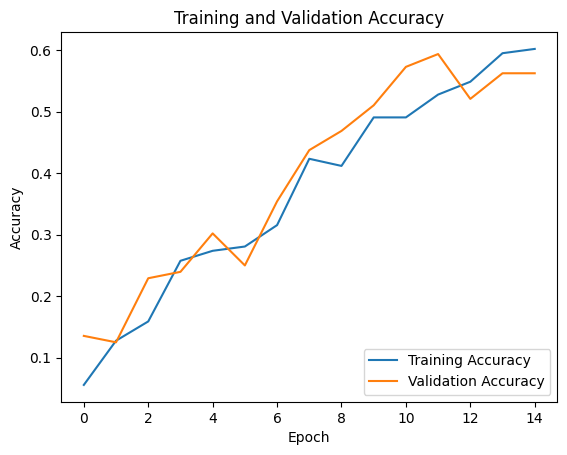

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 2s 196ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.6333333333333333
F1 Score: 0.6115642958275579
Precision: 0.6412653495741731
Recall: 0.6333333333333333


## LSTM + GRU

In [ ]:
input_layer = keras.layers.Input(shape=(1,), dtype=tf_string)
x_v = vect_layer(input_layer)
emb = keras.layers.Embedding(num_tokens, embedding_dim, embeddings_initializer=keras.initializers.Constant(embedding_matrix), trainable=False)(x_v)
x = keras.layers.LSTM(256, return_sequences=True)(emb)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.GRU(128, return_sequences=False)(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(64, 'relu')(x)
x = keras.layers.Dense(32, 'relu')(x)
x = keras.layers.Dropout(0.1)(x)
output_layer = keras.layers.Dense(y_train.shape[1], activation='softmax')(x)


model = keras.Model(input_layer, output_layer)
model.summary()


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 6000)              0         
 ctorization)                                                    
                                                                 
 embedding_7 (Embedding)     (None, 6000, 300)         12000600  
                                                                 
 lstm_3 (LSTM)               (None, 6000, 256)         570368    
                                                                 
 dropout_11 (Dropout)        (None, 6000, 256)         0         
                                                                 
 gru (GRU)                   (None, 128)               148224    
                                                           

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='ft_weights.best.tf.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[model_checkpoint_callback], epochs=epochs, batch_size=batch_size)

Epoch 1/15
27/27 [==============================] - 102s 4s/step - loss: 2.9759 - accuracy: 0.0684 - val_loss: 2.9820 - val_accuracy: 0.0833
Epoch 2/15
27/27 [==============================] - 94s 4s/step - loss: 2.9424 - accuracy: 0.0905 - val_loss: 2.9469 - val_accuracy: 0.0625
Epoch 3/15
27/27 [==============================] - 93s 4s/step - loss: 2.8714 - accuracy: 0.1009 - val_loss: 2.8937 - val_accuracy: 0.0729
Epoch 4/15
27/27 [==============================] - 97s 4s/step - loss: 2.8037 - accuracy: 0.1137 - val_loss: 2.8178 - val_accuracy: 0.0938
Epoch 5/15
27/27 [==============================] - 100s 4s/step - loss: 2.7450 - accuracy: 0.1206 - val_loss: 2.7875 - val_accuracy: 0.1354
Epoch 6/15
27/27 [==============================] - 16s 574ms/step - loss: 2.6363 - accuracy: 0.1473 - val_loss: 2.8696 - val_accuracy: 0.0833
Epoch 7/15
27/27 [==============================] - 16s 576ms/step - loss: 2.5972 - accuracy: 0.1671 - val_loss: 2.8030 - val_accuracy: 0.1146
Epoch 8/15
2

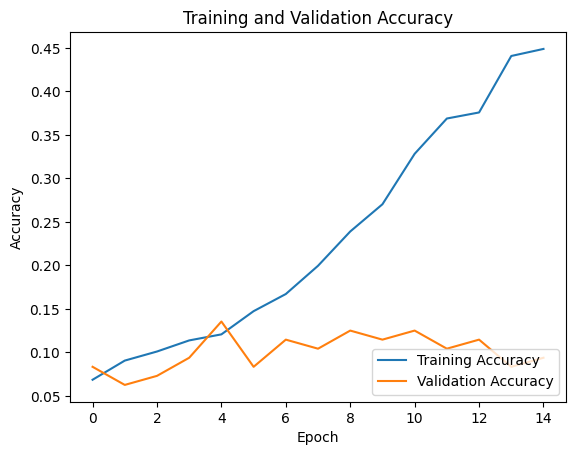

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

8/8 [==============================] - 3s 248ms/step


In [ ]:
accuracy_sc = accuracy_score(y_pred=y_pred,y_true=y_test_)
f1_sc = f1_score(y_pred=y_pred, y_true=y_test_, average='weighted')
precision_sc = precision_score(y_pred=y_pred, y_true=y_test_, average='weighted', zero_division = 0)
recall_sc = recall_score(y_pred=y_pred, y_true=y_test_, average='weighted')

print(f"Accuracy: {accuracy_sc}")
print(f"F1 Score: {f1_sc}")
print(f"Precision: {precision_sc}")
print(f"Recall: {recall_sc}")

Accuracy: 0.13333333333333333
F1 Score: 0.10359874011810029
Precision: 0.13138535138853474
Recall: 0.13333333333333333
